In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
from sklearn.cluster import KMeans
from math import radians, cos, sin, asin, sqrt

Memproses data...
Estimasi Biaya Gerobak selesai. Rata-rata: Rp 451,150 per TPS
Sedang membagi wilayah menjadi 30 Kecamatan (Pool)...

Data Siap: d:\College\Semester 7\Teknik Riset Operasi\Tubes\tubes_tro\dataset\final_dataset_2echelon.csv


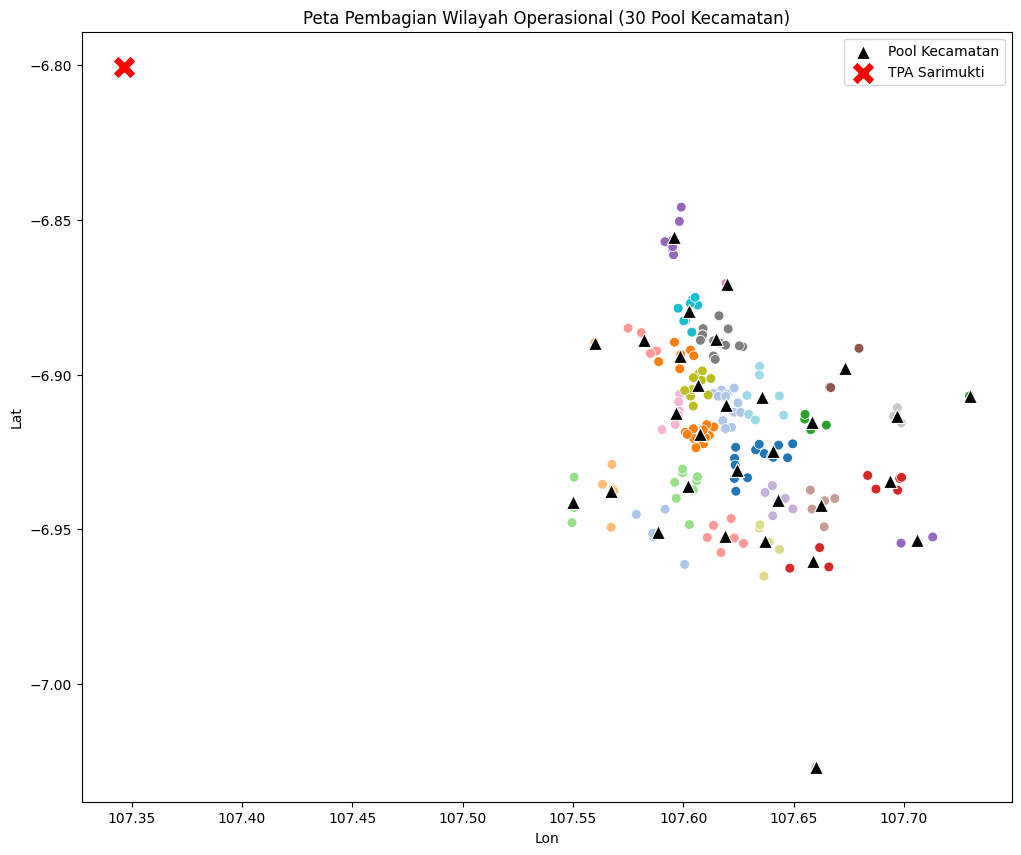

Selesai! Setiap warna mewakili satu area operasional Pool.


In [7]:
# ==========================================
# 1. SETUP PATH
# ==========================================
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebook':
    BASE_DIR = os.path.dirname(current_dir)
else:
    BASE_DIR = current_dir

DATA_DIR = os.path.join(BASE_DIR, 'dataset')
FIG_DIR = os.path.join(BASE_DIR, 'figures')
OUTPUT_FILE = os.path.join(DATA_DIR, 'final_dataset_2echelon.csv')

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# ==========================================
# 2. LOAD & CLEAN DATA
# ==========================================
file_fasilitas = os.path.join(DATA_DIR, 'fasilitas_full.csv')
file_capaian = os.path.join(DATA_DIR, 'jumlah_capaian_penanganan_sampah_di_kota_bandung.csv')

if not os.path.exists(file_fasilitas):
    raise FileNotFoundError("File 'fasilitas_full.csv' tidak ditemukan!")

print("Memproses data...")
df = pd.read_csv(file_fasilitas)
df_capaian = pd.read_csv(file_capaian)

# Clean Koordinat
df['Koordinat'] = df['Koordinat'].astype(str).str.strip()
df[['Lat', 'Lon']] = df['Koordinat'].str.split(',', expand=True).astype(float)
nodes = df[['Nama Fasilitas', 'Jenis', 'Lat', 'Lon']].copy()
nodes['Type'] = 'TPS'

# ==========================================
# 3. ESTIMASI DEMAND & BIAYA GEROBAK (ECHELON 1)
# ==========================================
# Demand (Sampah di TPS)
avg_daily_waste = (df_capaian[df_capaian['tahun']==2023]['jumlah_sampah'].mean()/30) if len(df_capaian)>0 else 1300
avg_per_tps = avg_daily_waste / len(nodes)

np.random.seed(42)
# Kapasitas Truk = 6 Ton (12 m3). Demand TPS variasi 2 s.d 5.5 Ton (biar truk bisa angkut >1 TPS)
nodes['Demand_Ton'] = np.round(np.clip(np.random.normal(avg_per_tps, 1.5, len(nodes)), 1.0, 5.5), 2)

# BIAYA GEROBAK (Transshipment Cost)
# Asumsi: Biaya angkut dari rumah ke TPS per ton
# Kita kasih faktor kesulitan (lokasi padat = lebih mahal)
difficulty = np.random.uniform(1.0, 1.3, size=len(nodes))
base_cost_gerobak = 75000 # Rupiah per ton
nodes['Cost_Gerobak'] = (nodes['Demand_Ton'] * base_cost_gerobak * difficulty).astype(int)

print(f"Estimasi Biaya Gerobak selesai. Rata-rata: Rp {nodes['Cost_Gerobak'].mean():,.0f} per TPS")

# ==========================================
# 4. CLUSTERING (PEMBAGIAN KECAMATAN)
# ==========================================
# Kita bagi 178 TPS menjadi 30 Zona (Asumsi 30 Kecamatan di Bandung)
print("Sedang membagi wilayah menjadi 30 Kecamatan (Pool)...")
kmeans = KMeans(n_clusters=30, random_state=42, n_init=10)
nodes['Kecamatan_ID'] = kmeans.fit_predict(nodes[['Lat', 'Lon']])

# ==========================================
# 5. GENERATE POOL & TPA
# ==========================================
# TPA Sarimukti (Hanya 1 untuk semua)
tpa = pd.DataFrame([{
    'Nama Fasilitas': 'TPA SARIMUKTI', 'Jenis': 'TPA', 'Type': 'TPA',
    'Lat': -6.8005, 'Lon': 107.3466, 'Demand_Ton': 0.0, 'Kecamatan_ID': -1, 'Cost_Gerobak': 0
}])

final_list = []

# Loop setiap Kecamatan untuk bikin POOL masing-masing
for kec_id in sorted(nodes['Kecamatan_ID'].unique()):
    # Ambil TPS di kecamatan ini
    tps_in_kec = nodes[nodes['Kecamatan_ID'] == kec_id]
    
    # Buat POOL di titik tengah (Centroid) kecamatan tersebut
    pool = pd.DataFrame([{
        'Nama Fasilitas': f'POOL KECAMATAN {kec_id}', 
        'Jenis': 'POOL', 'Type': 'POOL',
        'Lat': tps_in_kec['Lat'].mean(), 
        'Lon': tps_in_kec['Lon'].mean(), 
        'Demand_Ton': 0.0, 
        'Kecamatan_ID': kec_id, # Pool milik kecamatan ini
        'Cost_Gerobak': 0
    }])
    
    # Masukkan Pool dulu, baru TPS-nya
    final_list.append(pool)
    final_list.append(tps_in_kec)

# Gabung semua dan tambah TPA di akhir
final_data = pd.concat(final_list + [tpa], ignore_index=True)
final_data.reset_index(inplace=True)
final_data.rename(columns={'index': 'Node_ID'}, inplace=True)

# ==========================================
# 6. SIMPAN & VISUALISASI
# ==========================================
final_data.to_csv(OUTPUT_FILE, index=False)
print(f"\nData Siap: {OUTPUT_FILE}")

# Plot Peta Pembagian Wilayah
plt.figure(figsize=(12, 10))
# Plot TPS warnanya beda tiap kecamatan
sns.scatterplot(data=final_data[final_data['Type']=='TPS'], x='Lon', y='Lat', 
                hue='Kecamatan_ID', palette='tab20', legend=False, s=50)
# Plot Pool
sns.scatterplot(data=final_data[final_data['Type']=='POOL'], x='Lon', y='Lat', 
                color='black', marker='^', s=100, label='Pool Kecamatan')
# Plot TPA
sns.scatterplot(data=final_data[final_data['Type']=='TPA'], x='Lon', y='Lat', 
                color='red', marker='X', s=300, label='TPA Sarimukti')

plt.title('Peta Pembagian Wilayah Operasional (30 Pool Kecamatan)')
plt.savefig(os.path.join(FIG_DIR, 'peta_zona_kecamatan.png'))
plt.show()

print("Selesai! Setiap warna mewakili satu area operasional Pool.")

In [8]:
import pandas as pd
import numpy as np
import requests
import json
import os
import sys
import time
from math import ceil

# ==========================================
# 1. KONFIGURASI PATH & SERVER
# ==========================================
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebook':
    BASE_DIR = os.path.dirname(current_dir)
else:
    BASE_DIR = current_dir

DATA_DIR = os.path.join(BASE_DIR, 'dataset')
INPUT_FILE = os.path.join(DATA_DIR, 'final_dataset_2echelon.csv')
OUTPUT_MATRIX = os.path.join(DATA_DIR, 'distance_matrix_osrm.json')

# URL OSRM Public Demo Server
# Catatan: Server ini gratis tapi memiliki rate limit.
OSRM_TABLE_URL = "http://router.project-osrm.org/table/v1/driving/"

if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"File {INPUT_FILE} tidak ditemukan. Jalankan preprocessing dahulu.")

print("Memuat data nodes...")
df = pd.read_csv(INPUT_FILE)
n_nodes = len(df)
print(f"Total Node: {n_nodes} titik.")

# ==========================================
# 2. FUNGSI REQUEST OSRM (BATCHING)
# ==========================================
def get_osrm_matrix_chunk(source_coords, dest_coords):
    """
    Mengambil matriks jarak antara himpunan source dan dest.
    Format koordinat: "lon,lat"
    """
    # Gabungkan semua koordinat unik untuk URL string
    # OSRM Table membutuhkan string koordinat gabungan: "src1;src2;...;dst1;dst2;..."
    all_coords = source_coords + dest_coords
    coord_string = ";".join(all_coords)
    
    # Tentukan indeks source dan dest dalam string gabungan tersebut
    # Source ada di awal (index 0 sampai len(source)-1)
    src_indices = ";".join(map(str, range(len(source_coords))))
    
    # Dest ada di akhir (index len(source) sampai total-1)
    dest_indices = ";".join(map(str, range(len(source_coords), len(all_coords))))
    
    # Susun URL Request
    # annotations=distance (kita hanya butuh jarak, bukan durasi)
    request_url = f"{OSRM_TABLE_URL}{coord_string}?sources={src_indices}&destinations={dest_indices}&annotations=distance"
    
    try:
        response = requests.get(request_url)
        if response.status_code == 200:
            data = response.json()
            if data['code'] == 'Ok':
                return data['distances']
            else:
                print(f"OSRM Error Code: {data['code']}")
                return None
        elif response.status_code == 414:
            print("Error 414: URL terlalu panjang. Kurangi BATCH_SIZE.")
            return None
        elif response.status_code == 429:
            print("Error 429: Terlalu banyak request. Server sibuk.")
            time.sleep(5) # Tunggu sebentar
            return None
        else:
            print(f"HTTP Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Connection Error: {e}")
        return None

# ==========================================
# 3. PROSES UTAMA (LOOPING CHUNKS)
# ==========================================
# Siapkan array kosong N x N
full_matrix = np.zeros((n_nodes, n_nodes))

# Siapkan list koordinat string "lon,lat"
# OSRM mensyaratkan urutan Longitude, Latitude
coords_list = [f"{row['Lon']},{row['Lat']}" for _, row in df.iterrows()]

# Konfigurasi Batch
# Disarankan maks 40-50 agar URL tidak terlalu panjang untuk public server
BATCH_SIZE = 40 

num_batches = ceil(n_nodes / BATCH_SIZE)

print(f"Memulai pengambilan data OSRM dalam {num_batches} x {num_batches} batch...")
print("Mohon bersabar, proses ini membutuhkan waktu agar tidak terkena ban server.")

for i in range(0, n_nodes, BATCH_SIZE):
    for j in range(0, n_nodes, BATCH_SIZE):
        # Tentukan rentang Source (Baris) dan Dest (Kolom)
        src_end = min(i + BATCH_SIZE, n_nodes)
        dst_end = min(j + BATCH_SIZE, n_nodes)
        
        chunk_src = coords_list[i:src_end]
        chunk_dst = coords_list[j:dst_end]
        
        print(f"Processing: Source {i}-{src_end} ke Dest {j}-{dst_end}...", end="\r")
        
        # Request ke API
        distances = get_osrm_matrix_chunk(chunk_src, chunk_dst)
        
        if distances:
            # Masukkan hasil ke matriks utama
            # OSRM mengembalikan hasil dalam meter (float)
            full_matrix[i:src_end, j:dst_end] = distances
        else:
            print(f"\nGagal pada batch {i}-{j}. Menghentikan proses.")
            sys.exit()
            
        # Jeda waktu agar sopan terhadap server publik
        time.sleep(0.5) 

print("\nSelesai mengambil data dari OSRM.")

# ==========================================
# 4. SIMPAN HASIL
# ==========================================
# Ganti nilai None/NaN dengan angka besar (infinity) jika ada
full_matrix = np.nan_to_num(full_matrix, nan=999999999)

# Bulatkan ke integer (meter) agar kompatibel dengan OR-Tools
full_matrix_int = full_matrix.astype(int).tolist()

data_export = {
    'distance_matrix': full_matrix_int,
    'node_ids': df['Node_ID'].tolist(),
    'node_names': df['Nama Fasilitas'].tolist(),
    'source': 'OSRM Public Server'
}

with open(OUTPUT_MATRIX, 'w') as f:
    json.dump(data_export, f)

print(f"Matriks Jarak OSRM berhasil disimpan ke: {OUTPUT_MATRIX}")
print(f"Ukuran Matriks: {len(full_matrix_int)} x {len(full_matrix_int)}")

Memuat data nodes...
Total Node: 209 titik.
Memulai pengambilan data OSRM dalam 6 x 6 batch...
Mohon bersabar, proses ini membutuhkan waktu agar tidak terkena ban server.
Processing: Source 200-209 ke Dest 200-209...
Selesai mengambil data dari OSRM.
Matriks Jarak OSRM berhasil disimpan ke: d:\College\Semester 7\Teknik Riset Operasi\Tubes\tubes_tro\dataset\distance_matrix_osrm.json
Ukuran Matriks: 209 x 209
